# **Math Score model**

## Objectives

- Train and evaluate a model for predicting a student's math score

## Inputs

- outputs/datasets/filtered/math-score-dataset.csv
- outputs/datasets/split/math/math-test-score.csv
- outputs/datasets/split/math/math-train-score.csv
- outputs/datasets/split/math/math-test-vars.csv
- outputs/datasets/split/math/math-train-vars.csv

## Outputs

- A pipeline to predict a student's math score

## Additional comments

# Change working directory

Since this notebook exists in the jupyter_notebooks directory, we need to change the current working directory from the jupyter_notebooks directory to the workspace, so that any directories created in further codes cells are added in the correct place. 

We access the current directory with the OS packages' `getcwd()` method

In [1]:
import os
current_directory = os.getcwd()
current_directory


'/workspace/Exam-Scores-Analysis/jupyter_notebooks'

We now want to set the working directory as the parent of the current working directory, jupyter_notebooks

- The `os.path.dirname()` method gets the parent directory
- The `os.chir()` method defines the new current directory
- We do this to access all of the project's files and directories, rather than those in the jupyter_notebooks directory

In [2]:
os.chdir(os.path.dirname(current_directory))
print("You set a new current directory")

You set a new current directory


To make certain of things, we now use a code cell to confirm that we have set the current working directory properly

In [3]:
current_directory = os.getcwd()
current_directory

'/workspace/Exam-Scores-Analysis'

Import packages:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine.encoding import OrdinalEncoder

### Feature Scaling
from sklearn.preprocessing import StandardScaler

### Feature  Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Math Score pipeline

Considering that the math_score variable is a continuous numerical value, our objective in this notebook is to construct a pipeline for a regression model. We have previously noted only weak correlation levels between the categorical feature variables and the numerical target variables, so it is entirely possible that a regression model will fail to perform well enough to fulfil the business requirements. If that is the case, we will switch to using a classification model, using bins. 

First of all, let's load the required datasets:

In [5]:
df_maths = pd.read_csv('outputs/datasets/filtered/math-score-dataset.csv')
df_maths

,gender,ethnicity,parental_education,lunch_program,test_preparation_course,math_score
0,male,group A,high school,standard,completed,67
1,female,group D,some high school,free/reduced,none,40
2,male,group E,some college,free/reduced,none,59
3,male,group B,high school,standard,none,77
4,male,group E,associate's degree,standard,completed,78
...,...,...,...,...,...,...
995,male,group C,high school,standard,none,73
996,male,group D,associate's degree,free/reduced,completed,85
997,female,group C,some high school,free/reduced,none,32
998,female,group C,some college,standard,none,73


Now we load the train and test sets. We use the `squeeze()` method to transform the dataframe into a Series, as this is what the math_train_score and math_test_score variables were initially produced as.

In [6]:
math_train_vars = pd.read_csv('outputs/datasets/split/math/math-train-vars.csv')
math_train_score = pd.read_csv('outputs/datasets/split/math/math-train-score.csv').squeeze()
math_test_vars = pd.read_csv('outputs/datasets/split/math/math-test-vars.csv')
math_test_score = pd.read_csv('outputs/datasets/split/math/math-test-score.csv').squeeze()

## Pipeline

We will now define the pipeline that we will use. We know that our dataset's feature variables are categorical, so we need an ordinal categorical encoder step first. As we saw in the 07-FeatureEngineering notebook, none of the variables are sufficiently correlated to warrant a smart correlated selection step. We will then use a standard feature scaling and feature selection steps, and finally have the model step.

In [7]:
def PipelineOptimization(model):
  pipeline_base = Pipeline([

      ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                  variables = ['gender', 'ethnicity', 'parental_education', 'lunch_program', 'test_preparation_course'] ) ),      
       

      ("feature_scaling", StandardScaler() ),

      ("feature_selection",  SelectFromModel(model) ),

      ("model", model ),
       
    ])

  return pipeline_base

## Algorithm and Hyperparameter optimisation

We now need to determine the best algorithm to use, and then for that algorithm, the best hyperparameters. To do this, we will use the custom class defined in the [6 - Modeling and Evaluation - predict Tenure notebook of the Churnometer walkthrough project.](https://github.com/AdamBoley/churnometer/blob/main/jupyter_notebooks/06%20-%20Modeling%20and%20Evaluation%20-%20Predict%20Tenure.ipynb)



In [8]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, parameters):
        self.models = models
        self.parameters = parameters
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, x, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model =  PipelineOptimization(self.models[key])

            parameters = self.parameters[key]
            grid_search = GridSearchCV(model, parameters, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            grid_search.fit(x, y)
            self.grid_searches[key] = grid_search

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, parameters):
            summary = {
                 'estimator': key,
                 'minimum_score': min(scores),
                 'maximum_score': max(scores),
                 'mean_score': np.mean(scores),
                 'standard_deviation_score': np.std(scores),
            }
            return pd.Series({**parameters,**summary})

        rows = []
        for k in self.grid_searches:
            parameters = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                result = self.grid_searches[k].cv_results_[key]        
                scores.append(result.reshape(len(parameters), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(parameters, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'minimum_score', 'mean_score', 'maximum_score', 'standard_deviation_score']
        columns = columns + [column for column in df.columns if column not in columns]

        return df[columns], self.grid_searches


We can now select the algorithms to compare:

In [9]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

parameters_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Now we call the custom function using the training data

In [10]:
model_search = HyperparameterOptimizationSearch(models=models_quick_search, parameters=parameters_quick_search)
model_search.fit(math_train_vars, math_train_score, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

Now we can check which algorithm performed best

In [11]:
model_grid_search_summary, model_grid_search_pipelines = model_search.score_summary(sort_by='mean_score')
model_grid_search_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score
0,LinearRegression,0.218515,0.243797,0.278514,0.022808
2,RandomForestRegressor,0.165034,0.224148,0.3009,0.050323
3,ExtraTreesRegressor,0.171454,0.221568,0.296356,0.046533
1,DecisionTreeRegressor,0.171454,0.22154,0.296356,0.046562
5,GradientBoostingRegressor,0.123752,0.192383,0.272077,0.053964
4,AdaBoostRegressor,0.074394,0.144117,0.197792,0.043957
6,XGBRegressor,0.081181,0.143898,0.196024,0.042194


As we can see from the grid_search_summary dataframe, none of the algorithms perform particularly well, but the LinearRegression model performs best. Per the [SKlearn LinearRegression page](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html?highlight=linearregression#sklearn.linear_model.LinearRegression), this algorithm has no hyperparameters that we can use to optimise performance.

However, the RandomForestRegressor performed almost as well - it has a higher maximum score, but the mean score is brought down by the lower minimum score. The RandomForestRegressor has 5 hyperparameters that we can tweak, so we should see if these can boost performance to acceptable levels

In [12]:
models_search = {
    "RandomForestRegressor":RandomForestRegressor(random_state=0),
}

# Hyperparamters:
# https://docs.google.com/document/d/1PSug1nGF24NQHBByUzVFiNNKwvCMPLCc5x-ODfla28E/edit#

parameters_search = {
    "RandomForestRegressor":{'model__n_estimators': [100, 50, 140],
                             'model__max_depth': [None, 4, 15],
                             'model__min_samples_split': [2, 50],
                             'model__min_samples_leaf': [1, 50],
                             'model__max_leaf_nodes': [None, 50],
                            }
}


In [13]:
param_search = HyperparameterOptimizationSearch(models=models_search, parameters=parameters_search)
param_search.fit(math_train_vars, math_train_score, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [14]:
param_grid_search_summary, param_grid_search_pipelines = param_search.score_summary(sort_by='mean_score')
param_grid_search_summary

,estimator,minimum_score,mean_score,maximum_score,standard_deviation_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
52,RandomForestRegressor,0.177732,0.240071,0.308447,0.046176,15,None,1,50,50
4,RandomForestRegressor,0.177732,0.240071,0.308447,0.046176,None,None,1,50,50
16,RandomForestRegressor,0.177732,0.240071,0.308447,0.046176,None,50,1,50,50
64,RandomForestRegressor,0.177732,0.240071,0.308447,0.046176,15,50,1,50,50
15,RandomForestRegressor,0.178399,0.238844,0.30777,0.046856,None,50,1,50,100
...,...,...,...,...,...,...,...,...,...,...
44,RandomForestRegressor,0.123605,0.192887,0.235154,0.037528,4,50,50,2,140
20,RandomForestRegressor,0.123605,0.192887,0.235154,0.037528,None,50,50,2,140
23,RandomForestRegressor,0.123605,0.192887,0.235154,0.037528,None,50,50,50,140
35,RandomForestRegressor,0.123605,0.192887,0.235154,0.037528,4,None,50,50,140


As we suspected, it looks like optimising the hyperparameters has failed to produce a model of adequate performance. Let's check the best performing models:

In [15]:
best_model = model_grid_search_summary.iloc[0,0]
best_model

'LinearRegression'

In [16]:
best_model_and_params = param_grid_search_summary.iloc[0,0]
best_model_and_params

'RandomForestRegressor'

And then the parameters for those models:

In [17]:
model_grid_search_pipelines[best_model].best_params_

{}

In [18]:
param_grid_search_pipelines[best_model_and_params].best_params_

{'model__max_depth': None,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 50,
 'model__n_estimators': 50}

And then the best pipeline:

In [19]:
best_regressor_pipeline_1 = model_grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline_1

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'ethnicity',
                                           'parental_education',
                                           'lunch_program',
                                           'test_preparation_course'])),
                ('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=LinearRegression())),
                ('model', LinearRegression())])

In [20]:
best_regressor_pipeline_2 = param_grid_search_pipelines[best_model_and_params].best_estimator_
best_regressor_pipeline_2

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['gender', 'ethnicity',
                                           'parental_education',
                                           'lunch_program',
                                           'test_preparation_course'])),
                ('feature_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=0))),
                ('model',
                 RandomForestRegressor(min_samples_split=50, n_estimators=50,
                                       random_state=0))])

We can now assess which feature variables are the most important. Note that we can only do this for the RandomForestRegressor algorithm (best_regressor_pipeline_2), since the LinearRegression algorithm (best_regressor_pipeline_1) has no feature_importances_ method. Running the code cell below with the LinearRegression pipeline throws and error.

* These are the 3 most important features in descending order. The model was trained on them: 
['lunch_program', 'ethnicity', 'parental_education']


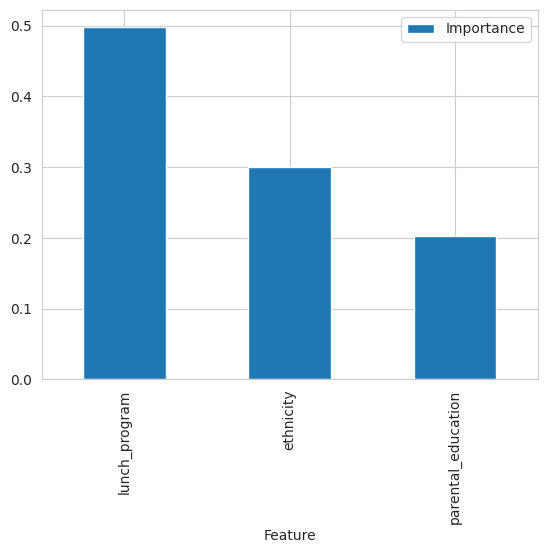

In [21]:
# after data cleaning and feat engine, the feature may space changes
data_cleaning_feat_eng_steps = 1 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline_2.steps[:data_cleaning_feat_eng_steps])
                                        .transform(math_train_vars)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline_2['feature_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline_2['feature_selection'].get_support()],
          'Importance': best_regressor_pipeline_2['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

This appears to support the conclusions we drew in the data analysis notebooks - the lunch_program variable has considerable importance, as to ethnicity and parental_education.

We can also evaluate the performance of our models on the train and test sets

In [22]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(math_train_vars, math_train_score, math_test_vars, math_test_score, pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(math_train_vars, math_train_score, pipeline)
	print("* Test Set")
	regression_evaluation(math_test_vars, math_test_score, pipeline)

def regression_evaluation(X, y, pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def regression_evaluation_plots(math_train_vars, math_train_score, math_test_vars, math_test_score, pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(math_train_vars)
  pred_test = pipeline.predict(math_test_vars)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=math_train_score , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=math_train_score , y=math_train_score, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=math_test_score , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=math_test_score , y=math_test_score, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

  plt.show()

Now we call the functions for the Linear Regression algorithm:

Model Evaluation 

* Train Set
R2 Score: 0.261
Mean Absolute Error: 10.708
Mean Squared Error: 175.588
Root Mean Squared Error: 13.251


* Test Set
R2 Score: 0.122
Mean Absolute Error: 11.754
Mean Squared Error: 201.474
Root Mean Squared Error: 14.194




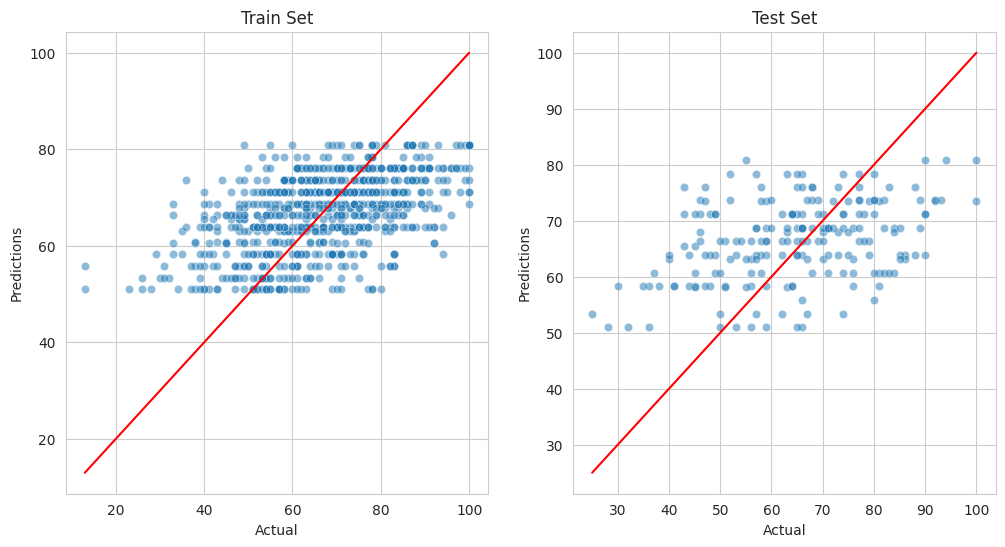

In [23]:
regression_performance(math_train_vars, math_train_score, math_test_vars, math_test_score, best_regressor_pipeline_1)
regression_evaluation_plots(math_train_vars, math_train_score, math_test_vars, math_test_score, best_regressor_pipeline_1)

And the function call for the RandomForestRegressor:

Model Evaluation 

* Train Set
R2 Score: 0.298
Mean Absolute Error: 10.438
Mean Squared Error: 167.001
Root Mean Squared Error: 12.923


* Test Set
R2 Score: 0.19
Mean Absolute Error: 11.303
Mean Squared Error: 185.911
Root Mean Squared Error: 13.635




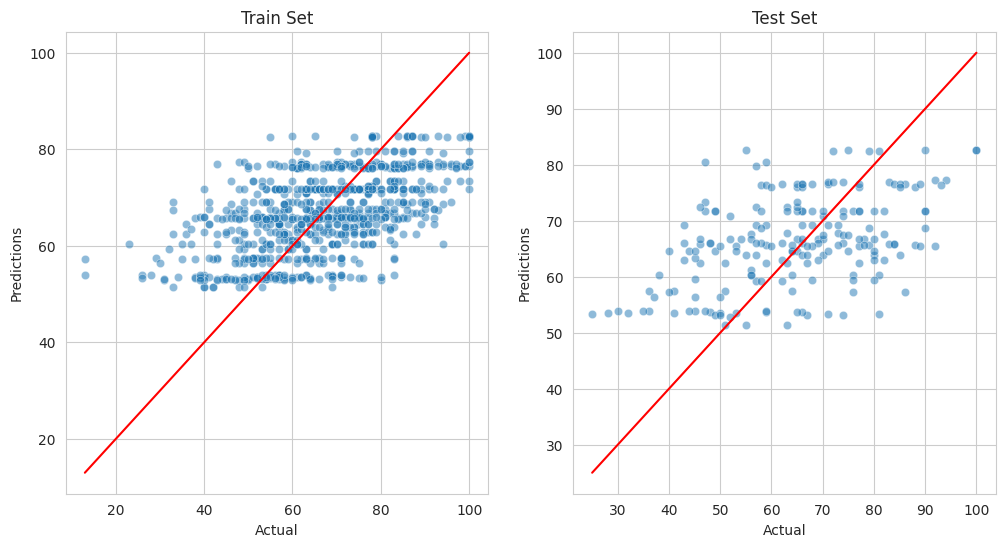

In [24]:
regression_performance(math_train_vars, math_train_score, math_test_vars, math_test_score, best_regressor_pipeline_2)
regression_evaluation_plots(math_train_vars, math_train_score, math_test_vars, math_test_score, best_regressor_pipeline_2)

The RandomForestRegressor appears to offer somewhat improved performance, but the R2 scores for both algorithms are poor.

As in the Churnometer project, we could try a Principal Component Analysis. However, we only have 5 feature variables, so this is unlikely to sufficiently improve performance. Instead, we will move straight to converting this task from regression to classification. To clearly separate matters, we will explore this classification task in the next notebook - 08b-math-score-model-classification.